# Graphs in ML - TP1 : Spectral clustering
### Dimitri Bouche (dimitri.bouche@ensae.fr)

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pyplot
import scipy.spatial.distance as sd
import scipy
import sklearn.cluster as skc
import sklearn.metrics as skm
from skimage import io
from skimage import color
import matplotlib.pyplot as plt
import sys
import os

# Local imports
from helper import *
from graph_construction.generate_data import *

## 1. Graph construction

In [108]:
def similarity_matrix(X, var):
    
    # l2 distance matrix
    dists = sd.squareform(sd.pdist(X))
    
    # Similarity matrix
    S = np.exp(-dists / var)
    
    return S

In [109]:
def build_epsilon_graph(X, var, eps):
    
    # Get similarity matrix and remove the diagonal
    S = similarity_matrix(X, var) - np.eye(X.shape[0])
    
    # Cut all links which weight is inferior to epsilon
    S = np.maximum(S - eps, 0)
    
    return S

In [119]:
def build_knn_graph(X, var, k=5):
    
    # Get similarity matrix and remove the diagonal
    S = similarity_matrix(X, var) - np.eye(X.shape[0])
    
    # Initialize directed neighbors similarity matrix
    Wdir = np.zeros(S.shape)
    
    # Fill directed neighbors similarity matrix
    for i in range(0, S.shape[0]):
        neighbors_inds = np.argsort(- S[i, :])[:k]
        Wdir[i, neighbors_inds] = S[i, neighbors_inds]
        
    # Symmetrization: S the "at least k neighbors" matrix
    S = np.maximum(Wdir, Wdir.T)    
    
    return S

### Build similarity graph function

In [111]:
def build_similarity_graph(X, var, eps, k):
    assert eps + k != 0, "Choose either epsilon graph or k-nn graph"
    if eps != 0:
        return build_epsilon_graph(X, var, eps)
    else:
        return build_knn_graph(X, var, k)

### Plot similarity graph

In [112]:
def plot_similarity_graph(X, Y, var, eps, k):
    W = build_similarity_graph(X, var, eps, k)
    plot_graph_matrix(X,Y,W)   

In [113]:
# Generate data from worst_case_blob function
X, Y = worst_case_blob(n_samples, gen_pam)

### Epsilon graph

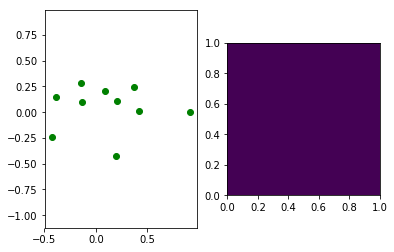

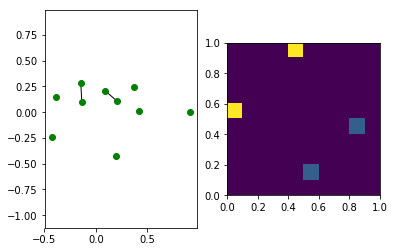

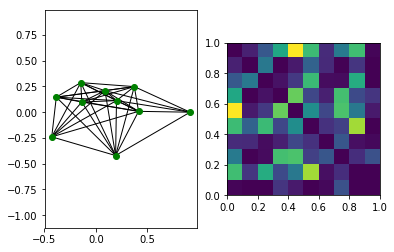

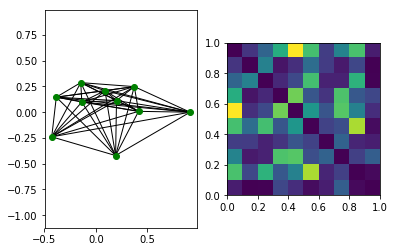

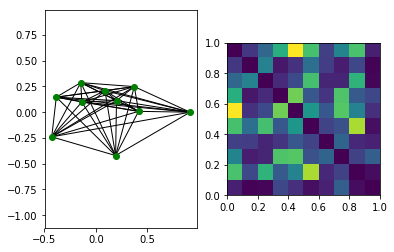

In [114]:
# Plot graph and similarity map for different values of epsilon 

# Parameters
n_samples = 10
gen_pam = 0.5
var = 0.3

epss = [1, 0.5, 0.05, 0.01, 0.005]
for eps in epss:
    plot_similarity_graph(X, Y, var, eps, 0)

In [115]:
def how_to_choose_epsilon(X, var, perturbation=0.99999999):
    
    # Get similarity matrix
    S = similarity_matrix(X, var)
    
    # Compute binary adjacency matrix of maximum spanning tree
    max_tree = max_span_tree(S)
    
    # Weighted adjacency matrix of maximum spanning tree
    a = max_tree * S
    
    # Epsilon is the weakest coef among the non null coeff in the weighted adjacency matrix of maximum spanning tree
    epsilon =  np.min(a[a != 0])
    
    # We artificially lower epsilon a bit so as to keep the weakest link of the tree
    return epsilon * perturbation

### Pourquoi choisit-on $\epsilon$ comme ça ?
Le "maximum spanning tree" ou arbre couvrant est un graphe dont l'ensemble d'arrête est inclus dans celles du graphe original et qui relie tout les noeuds de celui-ci. Dès lors si l'on prend $\epsilon$ égale au poid sur l'arrête la plus faible de l'arbre couvrant on s'assure une parcimonie maximale ($\epsilon$ le plus grand possible) sans toutefois casser la connectivité. Néanmoins, si l'on prend $\epsilon$ exactement égal à ce poid minimal, on casse quand même l'arrête, il faut donc perturber très légèrement cet $\epsilon$ optimal à la baisse. Nous faisons cela en le multipliant par une quantité strictement inférieur à 1 mais très proche de 1.

0.18883223318749284


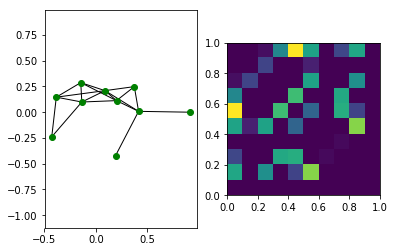

In [117]:
# How to chose epsilon test
eps_star = how_to_choose_epsilon(X, var)
print(eps_star)

# We plot the graph with optimal epsilon to check if it does fit our requirements
W = build_similarity_graph(X, var, eps_star, 0)
plot_graph_matrix(X,Y,W)

On constate effectivement que le graphe est parcimonieux (peu de connections) mais connecté (même les points extrêmes). C'est ce que nous voulions.

### Neighbors graph

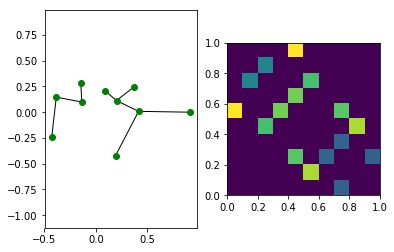

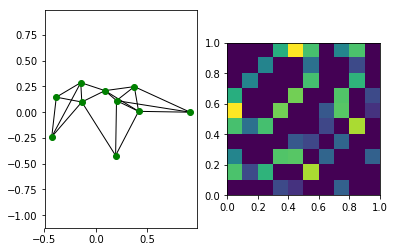

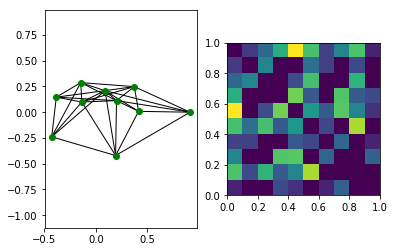

In [120]:
# Plot graph and similarity map for different number of neighbors

# Parameters
n_samples = 10
gen_pam = 0.5
var = 0.3

ks = [1, 3, 5]
for k in ks:
    plot_similarity_graph(X, Y, var, 0, k)

### 1.1 What is the purpose of the option parameter (gen_pam) in worst case blob ?
Ce paramètre a pour objectif d'ajouter un point "aberrant" au dataset (on ajoute un dernier point dont la première coordonnée est le maximum des coordonnées de tous les autres points auquel on ajoute en plus le paramètre **gen_pam**, sa seconde coordonnée étant 0. Dès lors plus **gen_pam** est grand, plus le point en question sera aberrant et donc difficile à connecter au reste (on devra forcément prendre un $\epsilon$ plus petit par exemple).

### 1.2 What happens when you change the generating parameter of worst_case_blob.m in how_to_choose_espilon.m and run the function? What if the parameter is very large?
Quand on change le paramètre **gen_pam**, comme justifié dans la précédente question, $\epsilon$ diminue. On le voit empiriquement dans les quelques testes ci-dessous. Quand **gen_pam** devient très grand, $\epsilon$ tend vers 0.

Text(0,0.5,'epsilon*')

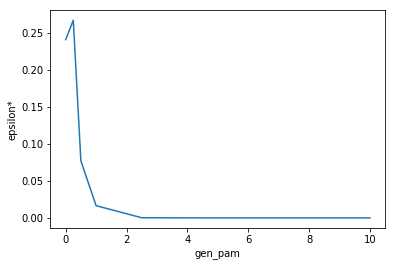

In [122]:
# Find epsilon optimal for several increasing values of gen_pams

# Grid of gen_pam values
gen_pams = [0, 0.25, 0.5, 1, 2.5, 5, 7.5, 10]

# Initialize list to store optimal values of epsilon
eps_stars = []

# Choose epsilon optimal for values of gen_pam in gen_pams and store them
for gen_pam in gen_pams:
    X, Y = worst_case_blob(n_samples, gen_pam)
    eps_star = how_to_choose_epsilon(X, var)
    eps_stars.append(eps_star)
    
# Plot the result
plt.plot(gen_pams, eps_stars)
plt.xlabel("gen_pam")
plt.ylabel("epsilon*")

### 1.3. Using plot_similarity_graph and one of the datasets, compare k-nn to ε graphs. When is it easier to build a connected graph using k-nn? When using ε graphs?

In [123]:
# Load the data 2blobs
data_blobs = scipy.io.loadmat(os.getcwd() + "/data/data_2blobs.mat")
X2blobs, Y2blobs = data_blobs["X"], data_blobs["Y"]

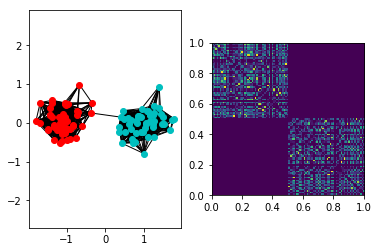

In [124]:
# Chose epsilon and plot the corresponding epsilon graph
eps_star = how_to_choose_epsilon(X2blobs, var)
plot_similarity_graph(X2blobs, Y2blobs, var, eps_star, 0)

Nous observons bien les deux aggrégats de points, le graphe reste toutefois connecté par un seul lien entre les deux aggrégats, ce qui montre que le choix de $\epsilon$ est pertinent.

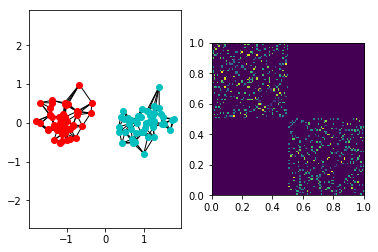

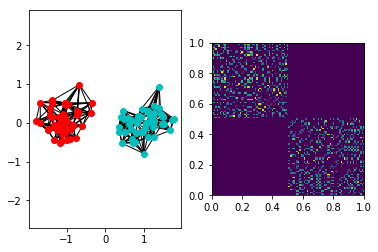

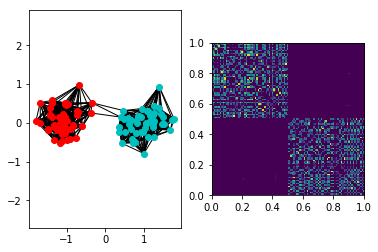

In [125]:
# KNN graph with different number of neighbors
for k in [5, 10, 20]:
    plot_similarity_graph(X2blobs, Y2blobs, var, 0, k)   

Les deux méthodes permettent d'obtenir un des graphes à la fois connectés et parcimonieux dans leurs liens d'une composante à l'autre. Néanmoins pour epsilon, le choix du paramètre epsilon est assez lourd (il faut trouver l'arbre couvrant maximal) alors que pour les k plus proches voisins, essayer quelque valeurs selon des heuristiques prenant en compte le nombre de points de données nous fournit rapidement un graphe connecté qui correspond à ce que l'on veut. Nous préfèrerons en conséquence cette dernière méthode pour la suite du TP.

# 2. Spectral clustering

### build_laplacian function

In [17]:
def build_laplacian(W, laplacian_normalization="unn"):
#  laplacian_normalization:
#      string selecting which version of the laplacian matrix to construct
#      either 'unn'normalized, 'sym'metric normalization
#      or 'rw' random-walk normalization

    # Create degree matrix
    D = np.diag(W.sum(axis=0))
    
    # Get size of adjacency matrix
    d = D.shape[0]
    
    # Compute symmetric Laplacian and return it
    if laplacian_normalization=="sym":
        Dinv_sqrt = np.diag(1 / np.sqrt(np.diag(D)))
        return np.eye(d) - np.dot(np.dot(Dinv_sqrt, W), Dinv_sqrt)
    
    # Compute random walk Laplacian and return it
    elif laplacian_normalization=="rw":
        Dinv = np.diag(1 / np.diag(D))
        return np.eye(d) - np.dot(Dinv, W)
    
    # Compute classic Laplacian and return it
    else:
        return D - W

### Spectral clustering function

In [126]:
def spectral_clustering(L, chosen_eig_indices, num_classes=2):

    # Eigen decomposition of Laplacian
    E, U = np.linalg.eig(L)
    
    # Get order index of eigen values
    order = np.argsort(E)
    
    # Reorder both eigen values and eigen vectors
    E, U = np.diag(E[order]), U[:, order]

    # Kmeans clustering on the lines of the selected eigenvectors
    kmeans_clustering = skc.KMeans(n_clusters=num_classes)
    kmeans_clustering.fit(U[:, chosen_eig_indices])

    # Get labels predicted by kmeans
    Y_rec = kmeans_clustering.labels_

    return Y_rec


### Two blobs clustering

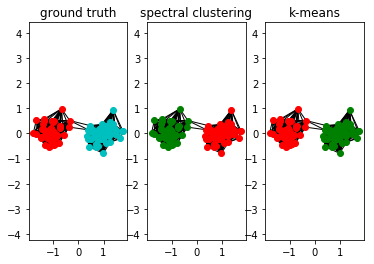

In [127]:
# Load the data 2blobs
data_blobs = scipy.io.loadmat(os.getcwd() + "/data/data_2blobs.mat")
X2blobs, Y2blobs = data_blobs["X"], data_blobs["Y"]

# automatically infer number of labels from samples
num_classes = len(np.unique(Y2blobs))

# exponential_euclidean's sigma^2
var = 0.3

# Laplacian normalization choice
laplacian_normalization = 'unn'

# indices of the ordered eigenvalues to pick
chosen_eig_indices = [1]

# Build graph
k = 20
W2blobs = build_similarity_graph(X2blobs, var, 0, k)

# Build Laplacian
L2blobs = build_laplacian(W2blobs, laplacian_normalization)

# Perform spectral clustering
Y_rec = spectral_clustering(L2blobs, chosen_eig_indices, num_classes=2)

# Plot clustering results (compare to ground truth and kmeans)
plot_clustering_result(X2blobs, Y2blobs, L2blobs, Y_rec,skc.KMeans(num_classes).fit_predict(X2blobs))

### Question 2.1
Supposons que le graphe est connecté (important car s'il n'est pas connecté $\mathbf{1}$ n'est pas le premier vecteur propre).

- Dans le cas où nous avons $c=2$ clusters, le problème de ratio cut peut s'exprimer de manière équivalente comme un problème de minimisation de forme quadratique définie par le Laplacien: $f^T L f$ sous contrainte que $f$ soit orthogonal au vecteur $\mathbf{1}$ et que toutes les composantes de $f$ soient des 1 ou des -1. Ce problème étant NP-hard on fait une relaxation en autorisant $f\in \mathbb{R}$ et en imposant $||f|| = \sqrt(n)$. La condition d'orthogonalité vient du fait que le vecteur $\mathbf{1}$ est le premier vecteur propre du Laplacian (associé à la plus petite valeur propre: 0). **Cela est vrai quelque soit le graphe (tant qu'il est connecté)** et en conséquence ce vecteur propre ne contient pas d'information sur le graphe. La solution au problème relaxé est par le théorème de Rayleigh-Ritz le second vecteur propre (associé à la seconde plus petite valeur propre) du Laplacien. Néanmoins, pour repasser du continu au discret il faut une règle de transformation. Pour ce faire, en pratique, nous utilisons un algorithme de clustering avec k=2 sur ses coordonnées. Kmeans fait par exemple l'affaire.

- Dans le cas $c>2$ clusters, un raisonnement du même type conduit à choisir les $c - 1$ vecteurs propres associés aux $c -1$ valeurs propres les plus petites en partant du second vecteur propre, le premier étant $\mathbf{1}$. On forme la matrice $V$ dont les colonnes sont ces vecteurs propres. Pour revenir à un problème discret on applique un algorithme de clustering aux lignes de $V$ pour $c$ clusters. Le cluster de la première ligne nous donne le cluster du premier point de données, le cluster de la seconde ligne celui du second et ainsi de suite.

### Question 2.2

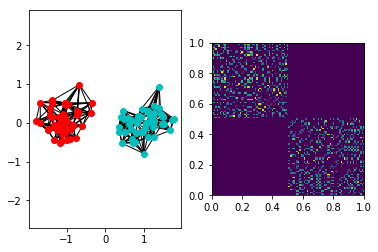

In [128]:
# Build disconnected graph
k = 10
W2blobs = build_similarity_graph(X2blobs, var, 0, k)
plot_similarity_graph(X2blobs, Y2blobs, var, 0, k)   

# Build Laplacian
L2blobs = build_laplacian(W2blobs, laplacian_normalization)

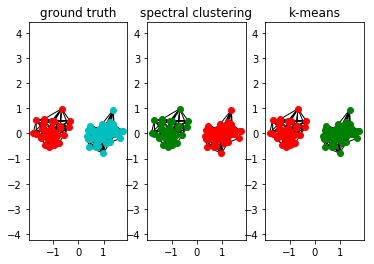

In [129]:
# indices of the ordered eigenvalues to pick
chosen_eig_indices = [0, 1]
Y_rec = spectral_clustering(L2blobs, chosen_eig_indices, num_classes=2)

# Plot clustering results (compare to ground truth and kmeans)
plot_clustering_result(X2blobs, Y2blobs, L2blobs, Y_rec,skc.KMeans(num_classes).fit_predict(X2blobs))

### Question 2.2 (justification)
Dans le cas où le graphe n'est pas connecté, $\mathbf{1}$ n'est plus vecteur propre associée à la plus petite valeur propre $0$. Dans ce cas, la multiplicité de la valeur propre $0$ est égale au nombre de composantes connectées du graphe et les vecteurs propres associées sont les vecteurs indicateurs de chaque composante connectée. Dès lors nous choisissons les deux premières valeurs propres puisque leurs vecteurs propres associés résument entièrement les deux composantes connectées.

### Question 2.3

In [133]:
def choose_eig_function(eigenvalues):
    
    # discrete variation of eigen values
    diffs = np.diff(eigenvalues)
    
    # Average of discrete variation
    avg_diff = np.mean(diffs)
    
    # We select up to the first strictly above average eigen value variation
    selected = np.argwhere(diffs > avg_diff)[0][0]
    eig_ind = list(range(1, selected + 1))
    
    return eig_ind

### Explication de la selection automatique
La règle de pouce consiste à chercher une rupture dans les valeurs propres (qui n'existe pas forcément d'ailleurs). Une heuristique simple pour chercher cette rupture est de calculer les variations des valeurs propres, de calculer la moyenne de ces variations et de s'arrêter la première fois que l'on a une variation supérieure strictement à la moyenne des variations.

In [134]:
def spectral_clustering_adaptive(L, num_classes=2):

    # Eigen decomposition of Laplacian
    E, U = np.linalg.eig(L)
    
    # Get order index of eigen values
    order = np.argsort(E)
    
    # Reorder both eigen values and eigen vectors
    E, U = np.diag(E[order]), U[:, order]

    # Choose eigen indices according to the choose_eig_function
    eigenvalues = np.diag(E)
    chosen_eig_indices = choose_eig_function(eigenvalues)

    # Kmeans clustering on the lines of the selected eigenvectors
    kmeans_clustering = skc.KMeans(n_clusters=num_classes)
    kmeans_clustering.fit(U[:, chosen_eig_indices])

    # Get labels predicted by kmeans
    Y_rec = kmeans_clustering.labels_

    return Y_rec

### Find the bend

In [135]:
def find_the_bend(sigma, k):

    # the number of samples to generate
    num_samples = 600

    # Load data
    [X, Y] = blobs(num_samples, 4, sigma)

    # Automatically infer number of clusters from samples
    num_classes = len(np.unique(Y));

    # Experiment parameters
    var = 0.3
    laplacian_normalization = 'unn'

    # Compute first 15 eigenvalues and sort them (for plotting purposes)
    W = build_similarity_graph(X, var, 0, k)
    L = build_laplacian(W, laplacian_normalization)                
    E, U = np.linalg.eig(L)
    order = np.argsort(E)
    eigenvalues = E[order][:15]

    # Choice of eigen values using choose_eig_function
    chosen_eig_indices = choose_eig_function(eigenvalues) # indices of the ordered eigenvalues to pick
    print("Automatic choice of eigenvalues: " + str(chosen_eig_indices))

    # Plot the eigen values
    plt.plot(eigenvalues)
    plt.ylabel("Eigenvalue")

    # Non adaptive spectral clustering
    Y_rec_nonadapt = spectral_clustering(L, chosen_eig_indices=list(range(1, num_classes)), num_classes=num_classes)
    
    # Adaptive spectral clustering
    Y_rec_adapt = spectral_clustering_adaptive(L, num_classes)

    # Plot the result for the adaptative version
    plot_the_bend(X, Y, L, Y_rec_adapt, eigenvalues)

#### Test avec $\sigma^2 =0.03$

Automatic choice of eigenvalues: [1, 2, 3]


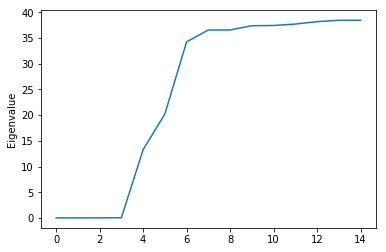

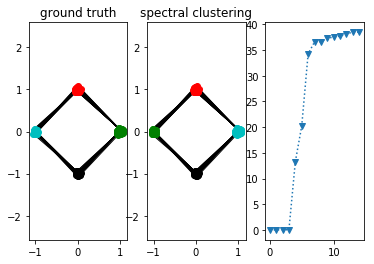

In [136]:
find_the_bend(sigma=0.03, k = 50)

Nous observons que pour cette valeur de $\sigma^2$, le saut dans les valeurs propres est très net. Notre méthode de sélection automatique est pertinente puisque nous trouvons exactement les indexes des valeurs propres qui sont avant la rupture (en enlevant la première donc l'indice 0).

### Question 2.4: Test avec $\sigma^2 =0.2$

Automatic choice of eigenvalues: [1, 2, 3]


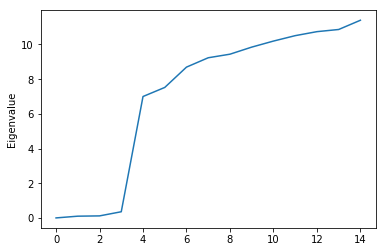

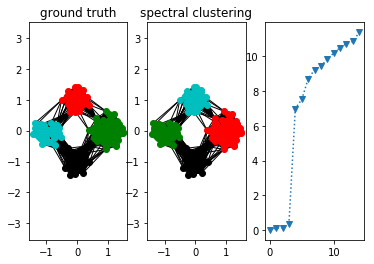

In [137]:
find_the_bend(sigma=0.2, k=50)

Nous observons ici que le saut est moins net que dans le cas précédent (bien que toujours bien visible).

### Question 2.5
Nous avons utilisé kmeans pour  assigner les points aux clusters. Il existe effectivement d'autres possibilités (le seuillage positif/négatif en est une). Néanmoins, dans **A tutorial on spectral clustering - Ulrik Von Luxburg (2006)**, il est souligné que bien que l'utilisation de Kmeans ne soit pas complètement justifiable théoriquement, on peut lui trouver une certaine justification: la distance euclidienne sur l'espace spectrale est une bonne mesure de distance sur le graphe. Effectivement cette-dernière peut être assimilée à la "commute distance" entre deux vertex définie comme l'espérance du temps de passage de l'un à l'autre d'une certaine marche aléatoire sur le graphe.

### Question 2.6
Regarder l'évolution des valeurs propres peut aussi nous aider à savoir si les clusters sont proches les uns des autres. Autrement dit, plus la croissance des valeurs propres est progressive, plus les clusters sont proches/se chevauchent (et donc plus le problème est compliqué).

### Two moons clustering

In [138]:
def two_moons_clustering(k=10):
    
    # Load the data
    in_data = scipy.io.loadmat(os.getcwd() +'/data/data_2moons')
    X = in_data['X']
    Y = in_data['Y']

    # Automatically infer number of labels from samples
    num_classes = len(np.unique(Y))

    # Parameters
    var = 0.3
    laplacian_normalization = "unn"
    chosen_eig_indices = list(range(1, num_classes +1))

    # Build graph and Laplacian
    W = build_similarity_graph(X, var, 0, k)
    L = build_laplacian(W, laplacian_normalization)

    # Perform spectral clustering
    Y_rec = spectral_clustering(L, chosen_eig_indices=list(range(1, num_classes)), num_classes=num_classes)

    # Plot the result
    plot_clustering_result(X, Y, L, Y_rec,skc.KMeans(num_classes).fit_predict(X))


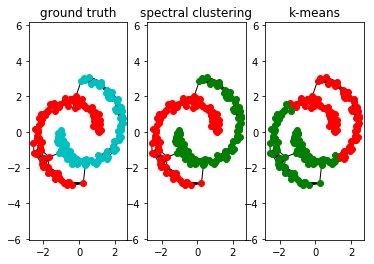

In [139]:
two_moons_clustering(k=7)

### Question 2.7
Le spectral clustering nous donne exactement ce que l'on voulait trouver (ground truth) alors que k-means "coupe en deux" l'ensemble de points ratant ainsi les deux clusters. Une explication possible est que k-means fonctionne en termes de distances globales (la distance euclidienne entre les points dans l'espace de départ) alors que le spectral clustering utilise les distances locales qui lui sont fournis par la structure du graphe de similarité. Dès lors puisque les points sont intensément connectés à l'intérieur des cluster, les distances intra clusters sont faibles. En revanche au vu du nombre de connections cross clusters, la distance d'un cluster à l'autre est très grande. En revanche si l'on met trop de voisins, on obtient des résultats tout aussi désastreux avec le spectral clustering qu'avec kmeans puisque l'on rapproche les deux clusters (cf figure infra).

#### Si l'on a trop de voisins !

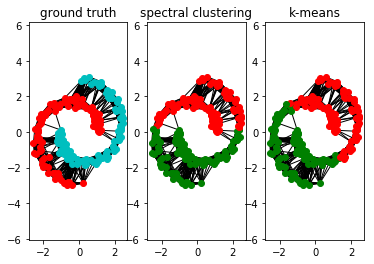

In [140]:
two_moons_clustering(k=20)

### Point and circle clustering

In [141]:
def point_and_circle_clustering(k=10):

    # Load the data
    in_data = scipy.io.loadmat(os.getcwd() + '/data/data_pointandcircle')
    X = in_data['X']
    Y = in_data['Y']

    # Automatically infer number of labels from samples
    num_classes = len(np.unique(Y))

    # Parameters
    var = 0.3
    chosen_eig_indices = list(range(1, num_classes +1))

    # Build Laplacians (classic and random walk)
    W = build_similarity_graph(X, var, 0, k)
    L_unn = build_laplacian(W, laplacian_normalization="unn")
    L_norm = build_laplacian(W, laplacian_normalization="rw")

    # Perform spectral clustering with each Laplacian
    Y_unn = spectral_clustering(L_unn, chosen_eig_indices=list(range(1, num_classes)), num_classes=num_classes)
    Y_norm = spectral_clustering(L_norm, chosen_eig_indices=list(range(1, num_classes)), num_classes=num_classes)

    # Plot the results
    plot_clustering_result(X, Y, L_unn, Y_unn, Y_norm, 1)

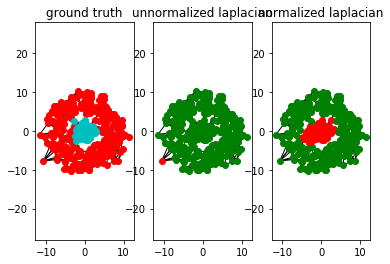

In [142]:
point_and_circle_clustering(k=7)

### Question 2.8
Nous voyons que dans ce cas, $L_{unn}$ ne fournit pas le résultat attendu alors que $L_{rw}$ trouve les clusters désirés. Selon le problème considéré: **Ratio Cut** ou **N Cut** l'objectif relaxé fait intervenir respectivement $L_{unn}$ or $L_{rw}$. Les deux problèmes ne sont toutefois pas équivalents. S'ils cherchent tous les deux à minimiser la dissimilarité entre les deux clusters, **N Cut** cherche aussi à maximiser la similarité intra-cluster qui n'intervient pas directement dans l'objectif de **Ratio Cut** ($|A|$ et $|\bar{A}|$ sont des nombres de noeuds, pas d'arrêtes). Effectivement dans **Ratio cut** on cherche à couper le moins de liens possibles tout en ayant des clusters non triviaux. Alors que dans **N cut** nous cherchons aussi à maximiser le nombre de lien intra-cluster ($vol(A)$ et $ vol(\bar{A})$ mesure des nombres d'arrêtes). 

Or dans notre dataset, on voit que les clusters sont très proches (il y a donc nécéssairement beaucoup de liens cross clusters). Cela explique les difficultés de la relaxation de **Ratio Cut** qui ne veut pas couper trop de liens. C'est la densité des liens intra clusters qui permet de faire la différence et **N Cut** la prend en compte. Dès lors il est assez logique de voir le problème relaxé de **N Cut** fournir de meilleures performances que celui de **Ratio Cut**.

D'ailleurs, pour cette raison (et d'autres non exposées ici), **A tutorial on spectral clustering - Ulrik Von Luxburg (2006)** conseille l'utilisation systématique du "Random walk" Laplacian pour le Spectral clustering.

In [143]:
def parameter_sensitivity():

    # The number of samples to generate
    num_samples = 500

    # Parameters
    var = 0.3
    laplacian_normalization = "rw"
    chosen_eig_indices = [1]

    # List of number of neighbors to test
    parameter_candidate = list(range(3, 150))
    
    # List to store score for each
    parameter_performance = []


    for k in parameter_candidate:

        # Load the data
        [X, Y] = two_moons(num_samples,1,0.02)

        # Automatically infer number of labels from samples
        num_classes = len(np.unique(Y))
        
        # Build graph and Laplacian
        W = build_similarity_graph(X, var, 0, k)
        L =  build_laplacian(W, laplacian_normalization='')

        # Perform spectral clustering
        Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes)

        # Append score to score list
        parameter_performance += [skm.adjusted_rand_score(Y,Y_rec)]

    # Plot the results
    plt.figure()
    plt.plot(parameter_candidate, parameter_performance)
    plt.title('parameter sensitivity')
    plt.show()

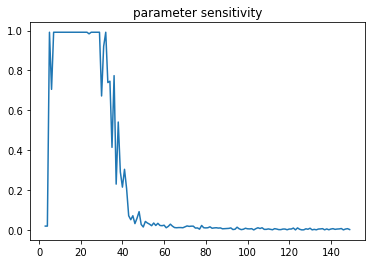

In [144]:
parameter_sensitivity()

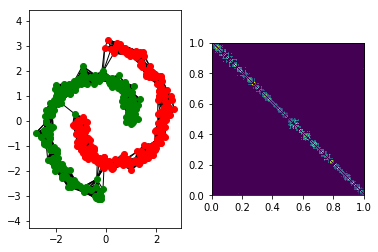

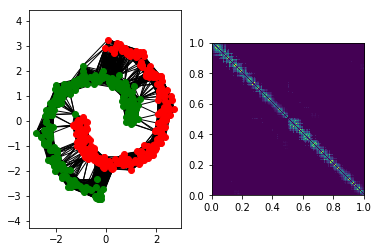

In [34]:
# Plot two graphs, one with "ideal number of neighbor" and one with two many neighbors

# Number of samples
num_samples = 500

# Variance parameter for similarity matrix
var = 0.3 

# Generate the data
[X, Y] = two_moons(num_samples,1,0.02)

# Plot the graphs in the two cases
for k in [20, 40]:
    W = build_similarity_graph(X, var, 0, k)
    plot_similarity_graph(X, Y, var, 0, k)   

### Question 2.9
Nous avons représenté le set de données dans deux cas $k=20$ et $k=40$. Le premier semble être assez optimal d'après le graphe de "parameter sensibility" plus haut. Le second correspond au moment où cela ne se passe plus très bien. Dès lors on observe empiriquement que quand il y commence à y avoir une densité significatives de liens cross-clusters le spectral clustering fonctionne beacoup moins bien voire plus du tout. C'est logique puisque lorsque les distances "locales" finissent pas lier intensément les deux clusters on perd l'intérêt du spectral clustering et on se rapproche alors assez rapidement du comportement de K-means.

### Question 2.10
Lorsque nous n'avons pas accès aux vrais labels, il est vain d'essayer d'évaluer un algorithme de clustering de manière absolue sur une échelle de performance comme nous pouvons le faire lorsque nous avons les labels. Nous pouvons seulement en ce cas trouver des mesures dites "internes" qui permettent de décider (de façon plus ou moins pertinente) entre deux algorithmes de clustering appliqués à un même jeu de données lequel est le plus pertinent. Il existe alors une pléthores de mesures différentes pour effectuer de telles comparaisons **(Comparing clusterings: An overview - Silke Wagner and Dorothea Wagner (2003))**.

### Question 3

### Image segmentation

In [88]:
def load_and_reshape_image(filename):
    
    # Load file
    X = plt.imread(filename)
    
    # Normalize file
    X = (X - np.min(X)) / (np.max(X) - np.min(X))
    
    # Get dimensions
    im_side = np.size(X,1)
    
    # "Flatten" image
    Xr = X.reshape(im_side**2,3)
    
    return X, Xr

In [85]:
def image_segmentation(Xr, var, k, laplacian_normalization, nvp, num_classes=5):
    
    # Build knn similarity graph
    W = build_similarity_graph(Xr, var, 0, k)
    
    # Build Laplacian 
    L = build_laplacian(W, laplacian_normalization)
    
    # Convert Laplacian to scipy sparse format
    L = scipy.sparse.bsr_matrix(L)
    
    # Perform eigen decomposition using scipy.sparse.linalg
    E, U = scipy.sparse.linalg.eigs(L, which="SM")
    # Cast imaginary parts to 0 since they are effectively 0 but it generates warnings otherwise
    U = np.real(U)
    
    # Get eigen values order and reorder eigenvectors according to this order
    order = np.argsort(E)
    U = U[:, order]
    
    # Perform clustering on spectral space using kmeans
    kmeans = skc.KMeans(n_clusters=num_classes).fit(U[:, 1:nvp + 1])
    
    # Get the labels
    Y_rec = kmeans.labels_
    
    return Y_rec

### Question 3.1

#### Test on "fruit_salad.bmp"

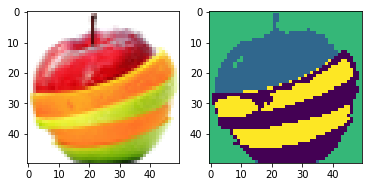

In [89]:
# Parameters
var = 0.3
k = 40
num_classes = 4
nvp = num_classes - 1
laplacian_normalization = "rw"

# Load and normalize data
filename = os.getcwd() + '/'+ "fruit_salad.bmp"
X, Xr = load_and_reshape_image(filename)

# Apply image segmentation
Y_rec = image_segmentation(Xr, var, k, laplacian_normalization, nvp, num_classes)

# Plot the results of the previous image segmentation
plt.figure()
plt.subplot(1,2,1)
plt.imshow(X)
plt.subplot(1,2,2)
Y_rec=Y_rec.reshape(im_side, im_side)
plt.imshow(Y_rec)
plt.show()

#### Test on "four_elements.bmp"

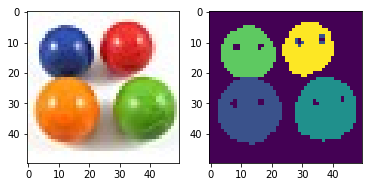

In [97]:
# Parameters
var = 0.3
k = 50
num_classes = 5
nvp = num_classes - 1
laplacian_normalization = "rw"

# Load and normalize data
filename = os.getcwd() + '/'+ "four_elements.bmp"
X, Xr = load_and_reshape_image(filename)

# Apply image segmentation
Y_rec = image_segmentation(Xr, var, k, laplacian_normalization, nvp, num_classes)

# Plot the results of the previous image segmentation
plt.figure()
plt.subplot(1,2,1)
plt.imshow(X)
plt.subplot(1,2,2)
Y_rec=Y_rec.reshape(im_side, im_side)
plt.imshow(Y_rec)
plt.show()

### Question 3.2

- Une première amélioration (que nous avons implémenté dans la question précédente) est d'utiliser le fait que les graphes que l'on génèrent sont par nature parcimonieux "sparse" puisque l'on prend $\approx k$ voisins par pixel. Dès lors pour le cas précédent la matrice d'adjacence devrait avoir $2500^2$ coefficient, toutefois elle n'en a que $\approx 2 * 2500 * k$ différents de $0$. Puisque l'on a par définition $k << n$ il est rentable de ne stocker que les coefficients non nuls en stockant la matrice dans un format "sparse" (block sparse row format, compressed sparse row format, etc...). Ces ordres de grandeurs sont les mêmes pour le Laplacien. La bonne nouvelle est également que des librairies implémentent des routines d'algèbre linéaire de haut niveau (inversion, diagonalisation...) directement en format sparse qui vont beaucoup plus vite que les routines classiques sur une matrice non sparse, donc on gagne plusieurs ordres de grandeur non seulement au niveau stockage mais aussi au niveau calcul.


- Nous pourrions proposer la procédure suivante comme second axe d'amélioration:
    1. échantilloner seulement un certain nombre de pixels $m << n$ dans l'image pour constituer un dataset réduit $X'$ (en choisissant $m$ de manière à avoir une représentation correct de chaque groupe de couleur à segmenter dans le dataset réduit). 
    2. On fait ensuite le spectral clustering sur ce dataset réduit (on gagne beaucoup sur cette phase de calcul puisque l'opération de recherche des valeurs propres/espaces propre est très lourde : $O(n^3)$ sans connaissances sur la structure de la matrice, mais beaucoup moins si on utilise la sparsité comme conseillé au dessus). Une fois ce spectral clustering effectué, nous avons les labels prédits pour les $m$ pixels qui ont été échantillonés.
    3. On construit un graphe de similarité pour le dataset complet et l'on utilise une métrique de distance sur ce graphe de similarité pour "inférer" des $m$ labels que l'on ne connaît les $n-m$ que l'on ne connaît pas. Par exemple en prenant le label du noeud dont le label est connu le plus proche selon une certaine mesure (mesure de resistance sur le graphe, plus court chemin, etc...)

### Question 3.3
Nous avons utilisé pour la dernière question **eigs** qui utilise la structure sparse de la matrice laplacienne. Il faut convertir celle-ci en matrice sparse puis utiliser cette routine sparse. Si la matrice a vraiment peu de coefficients non nuls (ce qui est le cas pour le Laplacien, cf supra), **eigs** est plusieurs ordres de grandeur plus rapide que **eig**.